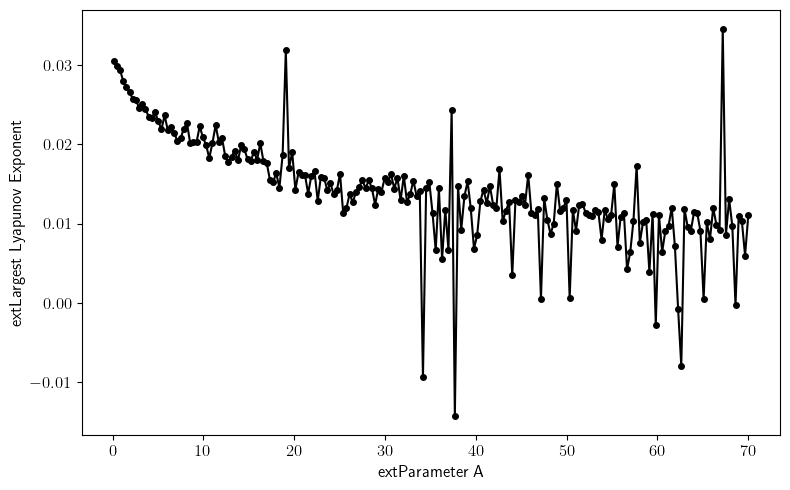

In [53]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True

# === Model parameters ===
rho1, rho2, rho3, rho4 = 0.0, 0.0, 0.0, 0.7
alpha1, alpha2, alpha3 = 0.0, 0.4, 0.0
delta2 = 0.6
phi1, phi2, phi3 = 1e-1, 0.0, 1e-1
gamma, eta = 0.3, 0.1
CC = 0.887
burstsize = 180

def system(t, y, A):
    """Right‐hand side of the 5D ODE."""
    B1, B2, B3, B4, P = y
    BA = B1 + B2 + B3 + B4
    dB1 = rho1*B1*(1 - BA/CC) - alpha1*A*B1 - phi1*P*B1
    dB2 = (rho2*B2*(1 - BA/CC)
           + alpha1*A*B1
           + alpha2*A*B3
           - (phi2+phi3)*P*B2
           - delta2*(A/(1 + A))*B2)
    dB3 = (rho3*B3*(1 - BA/CC)
           + phi1*P*B1
           - (alpha2+alpha3)*A*B3
           + phi2*P*B2
           - gamma*(P/(1 + P))*B3)
    dB4 = (rho4*B4*(1 - BA/CC)
           + alpha3*A*B3
           + phi3*P*B2
           - eta*((P + A)/(1 + P + A))*B4)
    dP  = (burstsize*(gamma*(P/(1 + P))*B3 + eta*(P/(1 + P))*B4)
           - (phi1*B1 + (phi2+phi3)*B3)*P)
    return np.array([dB1, dB2, dB3, dB4, dP])

def jacobian(y, A):
    """Analytical Jacobian ∂f/∂y."""
    B1, B2, B3, B4, P = y
    BA = B1 + B2 + B3 + B4
    J = np.zeros((5,5))
    # row 0
    J[0,0] = rho1*(1 - BA/CC) - rho1*B1/CC - alpha1*A - phi1*P
    J[0,1] = J[0,2] = J[0,3] = -rho1*B1/CC
    J[0,4] = -phi1*B1
    # row 1
    J[1,0] = alpha1*A
    J[1,1] = rho2*(1 - BA/CC) - rho2*B2/CC - (phi2+phi3)*P - delta2*(A/(1 + A))
    J[1,2] = alpha2*A
    J[1,3] = -rho2*B2/CC
    J[1,4] = -(phi2+phi3)*B2
    # row 2
    J[2,0] = phi1*P
    J[2,1] = phi2*P
    J[2,2] = (rho3*(1 - BA/CC) - rho3*B3/CC
              - (alpha2+alpha3)*A
              - gamma*(P/(1 + P)))
    J[2,3] = -rho3*B3/CC
    J[2,4] = phi1*B1 + phi2*B2 + gamma*B3/(1 + P)**2
    # row 3
    J[3,0] = -rho4*B4/CC
    J[3,1] = phi3*P
    J[3,2] = alpha3*A
    J[3,3] = (rho4*(1 - BA/CC) - rho4*B4/CC
              - eta*((P + A)/(1 + P + A)))
    J[3,4] = phi3*B2 + eta*B4/(1 + P + A)**2
    # row 4
    J[4,0] = -phi1*P
    J[4,1] = 0.0
    J[4,2] = burstsize*gamma*P/(1 + P) - (phi2+phi3)*P
    J[4,3] = burstsize*eta*P/(1 + P)
    J[4,4] = (burstsize*(gamma*B3/(1 + P)**2 + eta*B4/(1 + P)**2)
              - (phi1*B1 + (phi2+phi3)*B3))
    return J

def augmented_rhs(t, z, A):
    """
    Combined RHS for the state y (5) and tangent‐map U (5×5 flattened).
    z = [y, U.ravel()]
    """
    y = z[:5]
    U = z[5:].reshape(5,5)
    dy = system(t, y, A)
    dU = jacobian(y, A) @ U
    return np.concatenate([dy, dU.ravel()])

def lyapunov_variational(A, t_max=200.0, dt=0.5, transient=50.0):
    """
    Compute the largest Lyapunov exponent via discrete QR on the variational flow.
    """
    # initial state y0 and tangent‐map U0 = I
    y0 = np.random.rand(5)
    U0 = np.eye(5)
    z = np.concatenate([y0, U0.ravel()])

    # advance to end of transient
    sol = solve_ivp(augmented_rhs, [0, transient], z,
                    args=(A,), method='RK45', max_step=dt)
    z = sol.y[:, -1]
    t = transient

    sum_log = 0.0
    steps = int(np.ceil((t_max - transient) / dt))

    for _ in range(steps):
        # integrate one block of length dt
        sol = solve_ivp(augmented_rhs, [t, t + dt], z,
                        args=(A,), method='RK45', max_step=dt)
        z = sol.y[:, -1]
        t += dt

        # extract U and perform QR
        y = z[:5]
        U = z[5:].reshape(5,5)
        Q, R = np.linalg.qr(U)

        # accumulate log of the first diagonal (largest direction)
        sum_log += np.log(abs(R[0,0]))

        # reset U to Q, keep y
        z = np.concatenate([y, Q.ravel()])

    return sum_log / (steps * dt)

# === Sweep over A and plot ===
A_values = np.linspace(0.1, 70.0, 200)
lyap_values = [lyapunov_variational(A) for A in A_values]

plt.figure(figsize=(8,5))
plt.plot(A_values, lyap_values, 'o-', c='black',markersize=4)
plt.xlabel('\text{Parameter A}', fontsize=12)
plt.ylabel('\text{Largest Lyapunov Exponent}', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Lyapunov Exponent vs A (Variational + QR)')
#plt.grid(True)
plt.tight_layout()
plt.savefig('lyapunov_exponent.pdf')
plt.show()


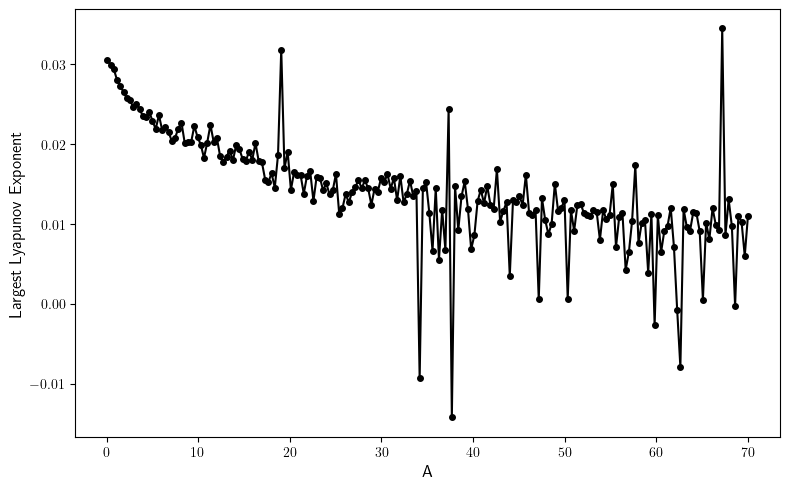

In [55]:
plt.figure(figsize=(8,5))
plt.plot(A_values, lyap_values, 'o-', c='black',markersize=4)
plt.xlabel('A', fontsize=12)
plt.ylabel('Largest Lyapunov Exponent', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.title('Lyapunov Exponent vs A (Variational + QR)')
#plt.grid(True)
plt.tight_layout()
plt.savefig('lyapunov_exponent.pdf')
plt.show()